# NOTEBOOK

In [25]:
#import files, download libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import make_scorer
from time import time
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import sqlite3

In [3]:
#Import data from SQL database
con = sqlite3.connect('database.sqlite')
cursor = con.cursor()

country_table = pd.read_sql_query("SELECT * FROM Country", con)
league_table = pd.read_sql_query("SELECT * FROM League", con)
match_table = pd.read_sql_query("SELECT * FROM Match", con)
player_table = pd.read_sql_query("SELECT * FROM Player", con)
player_att_table = pd.read_sql_query("SELECT * FROM Player_Attributes", con)
team_table = pd.read_sql_query("SELECT * FROM Team", con)
team_att_table = pd.read_sql_query("SELECT * FROM Team_Attributes", con)

In [4]:
#Importing data (Matrix design already created)
data=pd.read_csv('MatriceDXA.csv', delimiter=',')
labels = data.loc[:, 'label']
features = data.drop('label', axis=1)

In [5]:
#Let's check our features
data.columns.values.tolist()

['match_api_id',
 'home_team_goals_difference',
 'away_team_goals_difference',
 'games_won_home_team',
 'games_won_away_team',
 'games_against_won',
 'games_against_lost',
 'League_1.0',
 'League_1729.0',
 'League_4769.0',
 'League_7809.0',
 'League_10257.0',
 'League_13274.0',
 'League_15722.0',
 'League_17642.0',
 'League_19694.0',
 'League_21518.0',
 'League_24558.0',
 'Home_buildUpPlaySpeedClass',
 'Home_buildUpPlayDribblingClass',
 'Home_buildUpPlayPassingClass',
 'Home_buildUpPlayPositioningClass',
 'Home_chanceCreationPassingClass',
 'Home_chanceCreationCrossingClass',
 'Home_chanceCreationShootingClass',
 'Home_chanceCreationPositioningClass',
 'Home_defencePressureClass',
 'Home_defenceAggressionClass',
 'Home_defenceTeamWidthClass',
 'Home_defenceDefenderLineClass',
 'Away_buildUpPlaySpeedClass',
 'Away_buildUpPlayDribblingClass',
 'Away_buildUpPlayPassingClass',
 'Away_buildUpPlayPositioningClass',
 'Away_chanceCreationPassingClass',
 'Away_chanceCreationCrossingClass',
 'Aw

In [6]:
np.shape(data)

(21246, 45)

In [7]:
#Check if there are Missing values
count_nan = len(data) - data.count()
print(count_nan)

match_api_id                           0
home_team_goals_difference             0
away_team_goals_difference             0
games_won_home_team                    0
games_won_away_team                    0
games_against_won                      0
games_against_lost                     0
League_1.0                             0
League_1729.0                          0
League_4769.0                          0
League_7809.0                          0
League_10257.0                         0
League_13274.0                         0
League_15722.0                         0
League_17642.0                         0
League_19694.0                         0
League_21518.0                         0
League_24558.0                         0
Home_buildUpPlaySpeedClass             0
Home_buildUpPlayDribblingClass         0
Home_buildUpPlayPassingClass           0
Home_buildUpPlayPositioningClass       0
Home_chanceCreationPassingClass        0
Home_chanceCreationCrossingClass       0
Home_chanceCreat

# Check which features are the Best one 

In [8]:
dataFS=data
array = dataFS.values
X = array[:,1:43]

Y = array[:,44]

In [8]:
model = LogisticRegression(multi_class = "ovr")
rfe = RFE(model, 20)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Num Features: 20
Selected Features: [False False False False False  True  True  True  True  True  True  True
  True  True  True  True  True False False False  True False False False
  True False False False  True False  True  True  True False False False
  True  True False False False False]
Feature Ranking: [19  7  4 13  9  1  1  1  1  1  1  1  1  1  1  1  1 15 11 20  1  8  6  5
  1 14 23 18  1 21  1  1  1 12 16  3  1  1 10 22 17  2]


In [9]:
#Let's check the top 30 features to explain the output through a logistic regression model 
model = LogisticRegression()
rfe = RFE(model, 30)
fit = rfe.fit(X, Y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

c:\python27\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Num Features: 30
Selected Features: [False  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True False  True  True  True  True
  True False False False  True False  True  True  True False False  True
  True  True  True False False  True]
Feature Ranking: [ 9  1  1  3  1  1  1  1  1  1  1  1  1  1  1  1  1  5  1 10  1  1  1  1
  1  4 13  8  1 11  1  1  1  2  6  1  1  1  1 12  7  1]


# Modelization 

In [98]:
#Separating the data into training, testing set and calibrating set
X_train_calid, X_testid, y_train_cal, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, 
                                                                        stratify = labels)

X_trainid, X_calibrateid, y_train, y_calibrate = train_test_split(X_train_calid, y_train_cal, test_size = 0.3, random_state = 42, 
                                                              stratify = y_train_cal)

In [10]:
#Removing match_id for classifier training
X_train_cal = X_train_calid.drop(['match_api_id'],axis = 1)
X_test = X_testid.drop(['match_api_id'],axis = 1) 
X_train = X_trainid.drop(['match_api_id'],axis = 1) 
X_calibrate = X_calibrateid.drop(['match_api_id'],axis = 1)

In [11]:
LOG_clf = LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')
Softmax = LogisticRegression(multi_class = "multinomial", solver = "sag", class_weight = 'balanced')

In [12]:
## Training a baseline model and finding the best model composition using grid search
#Train a simple GBC classifier as baseline model
clf = LOG_clf
clf2 = Softmax
clf.fit(X_train, y_train)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test))))

c:\python27\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score of LogisticRegression for training set: 0.5039.
Score of LogisticRegression for test set: 0.4892.


In [13]:
#PCA and parameters for logreg Gridsearch 
feature_len = features.shape[1]
pca = PCA()
dm_reductions = pca
scorer = make_scorer(accuracy_score)
parameters_LOG = {'clf__C': np.logspace(0, 4, 7), 
                  'dm_reduce__n_components': np.arange(7, feature_len, np.around(feature_len/7))}

In [14]:
#Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

5

In [15]:
#Get accuracy score
def predict_labels(clf, best_pipe, features, target):
    ''' Makes predictions using a fit classifier based on scorer. '''
    
    #Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))
    end = time()
    
    #Print and return results
    print("Made predictions in {:.4f} seconds".format(end - start))
    return accuracy_score(target.values, y_pred)

In [73]:
#Train a classifier with a dimensinnality reduction (PCA,...), a CV sets, parameters for gridsearch, nbs of paralell jobs..
def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs):
    ''' Fits a classifier to the training data. '''
    
    #Start the clock, train the classifier, then stop the clock
    start = time()
    
        
        #Define pipeline of dm reduction and classifier
    estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
    pipeline = Pipeline(estimators)
        
    #Grid search over pipeline and return best classifier
    grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
    grid_obj.fit(X_train, y_train)
    best_pipe = grid_obj.best_estimator_
    params = grid_obj.best_params_    
    end = time()
    
    #Print the results
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    #Return best pipe
    return best_pipe, params

In [74]:
def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs):
    ''' Train and predict using a classifer based on scorer. '''
    
    #Indicate the classifier and the training set size
    print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
    
    #Train the classifier
    best_pipe, params = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
    #Calibrate classifier
    print("Calibrating probabilities of classifier...")
    start = time()    
    clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
    end = time()
    print("Calibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    # Print the results of prediction for both training and testing
    print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))
    
    #Return classifier, dm reduction, and label predictions for train and test set
    return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test), params

#### Logistic Regression without calibration

In [92]:
#Training a model without Calibration
Topmodel, paramlog = train_classifier(clf, dm_reductions,X_train,y_train,cv_sets,parameters_LOG,scorer,1)

Trained LogisticRegression in 2.5 minutes


In [96]:
#Score of Logreg without calibration
print("Score of {} for training set: {:.4f}".format("Logistic Regression",
                                                     predict_labels(Topmodel.named_steps['clf'], Topmodel, X_train, y_train)))
print("Score of {} for testing set: {:.4f}".format("Logistic Regression",
                                                     predict_labels(Topmodel.named_steps['clf'], Topmodel, X_test, y_test)))

Made predictions in 0.0150 seconds
Score of Logistic Regression for training set: 0.4974
Made predictions in 0.0060 seconds
Score of Logistic Regression for testing set: 0.4936


#### Logistic Regression with calibration

In [75]:
#Training a model with Calibration
Topmodel2, dm_reduce, train_score, test_score, params = train_calibrate_predict(clf, dm_reductions,X_train,y_train,X_calibrate, y_calibrate,X_test,y_test,cv_sets,parameters_LOG,scorer,1)

Training a LogisticRegression with PCA...
Trained LogisticRegression in 2.4 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.0190 seconds
Score of CalibratedClassifierCV for training set: 0.5202.
Made predictions in 0.0060 seconds
Score of CalibratedClassifierCV for test set: 0.5242.
Made predictions in 0.0190 seconds
Made predictions in 0.0050 seconds


In [76]:
dm_reduce

PCA(copy=True, iterated_power='auto', n_components=19, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [77]:
params

{'clf__C': 464.15888336127773, 'dm_reduce__n_components': 19}

#### Softmax without calibration

In [95]:
#Softmax training without calibration
Softmaxtrained, paramsoft = train_classifier(clf2, dm_reductions,X_train,y_train,cv_sets,parameters_LOG,scorer,1)

Trained LogisticRegression in 1.7 minutes


In [100]:
#Score of Softmax without calibration
print("Score of {} for training set: {:.4f}".format("Softmax",
                                                     predict_labels(Softmaxtrained.named_steps['clf'], Softmaxtrained, X_train, y_train)))
print("Score of {} for training set: {:.4f}".format("Softmax",
                                                     predict_labels(Softmaxtrained.named_steps['clf'], Softmaxtrained, X_test, y_test)))

Made predictions in 0.0270 seconds
Score of Softmax for training set: 0.4937
Made predictions in 0.0120 seconds
Score of Softmax for training set: 0.4826


#### Softmax with calibration

In [24]:
#Softmax training with calibration
Topmodel3, dm_reduce2, train_score2, test_score2 = train_calibrate_predict(clf2, dm_reductions,X_train,y_train,X_calibrate, y_calibrate,X_test,y_test,cv_sets,parameters_LOG,scorer,1)

Training a LogisticRegression with PCA...
Trained LogisticRegression in 2.3 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.0160 seconds
Score of CalibratedClassifierCV for training set: 0.5200.
Made predictions in 0.0060 seconds
Score of CalibratedClassifierCV for test set: 0.5224.
Made predictions in 0.0160 seconds
Made predictions in 0.0060 seconds


### Confusion Matrix for best model

In [30]:
def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, cmap=plt.cm.Blues, normalize = False):    
    ''' Plot confusion matrix for given classifier and data. '''
    
    #Define label names and get confusion matrix values
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels)
    
    #Check if matrix should be normalized
    if normalize == True:
        
        #Normalize
        cm = cm.astype('float') / cm.sum()
        
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title= "Confusion matrix of a {} with {}".format('Logistic regression', dim_reduce.__class__.__name__)   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()

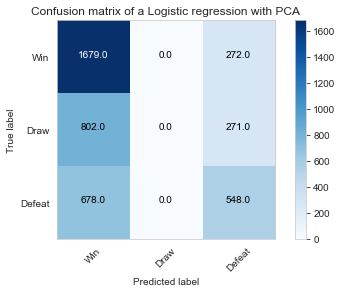

In [32]:
#Confusion Matrix
plot_confusion_matrix(y_test, X_test, Topmodel2, dm_reduce)

# Inclusion of Book keepers 

In [44]:
#Importing bookeeper odds (BW)
bk_odds=pd.DataFrame()
bk_odds=match_table[['match_api_id','BWH','BWD','BWA']]
bk_odds.head()
#Matrix with features|label|Bookkeepers odds
matrixodds = pd.merge(data,bk_odds, on = 'match_api_id', how = 'left')
matrixodds.head()

,match_api_id,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_1.0,League_1729.0,League_4769.0,...,Away_defencePressureClass,Away_defenceAggressionClass,Away_defenceTeamWidthClass,Away_defenceDefenderLineClass,home_players_ranking,away_players_ranking,label,BWH,BWD,BWA
0,493017.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,2,2,0,59.727273,64.090909,Win,2.95,3.25,2.20
1,493025.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,2,1,0,65.818182,68.545455,Defeat,3.10,3.00,2.20
2,493027.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,2,1,0,70.454545,61.000000,Win,1.35,4.00,9.00
3,493034.0,1.0,2.0,1.0,1.0,0.0,0.0,1,0,0,...,1,2,1,0,59.818182,70.545455,Win,4.70,3.30,1.70
4,493040.0,-2.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,1,1,2,0,62.090909,60.000000,Draw,1.60,3.55,5.05


In [45]:
#Data Frame with Book keepers odds |label
bookeeper = pd.DataFrame()
bookeeper = matrixodds[['match_api_id','BWH','BWD','BWA','label']]

# Trying to find the best bets

## Conversion to Book keepers odds to probability 

In [46]:
def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    #Define variables
    label = match_odds.loc[:,'label']
    match_id = match_odds.loc[:,'match_api_id']    
    win_odd = match_odds.loc[:,'BWH']
    draw_odd = match_odds.loc[:,'BWD']
    loss_odd = match_odds.loc[:,'BWA']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    probs.loc[:,'label'] = label
    
    #Return probs and meta data
    return probs

## Predicted class probabilities

In [47]:
#Data frame with predicted prod from best classifier
predprodtemp = pd.DataFrame(Topmodel2.predict_proba(dm_reduce.transform(X_test)), columns = ['defeat_prob',
                                                                                          'draw_prob', 'win_prob'])
predprob = pd.DataFrame()
predprob[['match_api_id']] = X_testid[['match_api_id']]
predprob.reset_index(inplace=True, drop=True)
predprob [['defeat_prob', 'draw_prob', 'win_prob']] = predprodtemp[['defeat_prob', 'draw_prob', 'win_prob']]

In [48]:
#Cancat predicted probabilities with book keepers probabilities
bkprob = convert_odds_to_prob(bookeeper)
probcomp= pd.merge(bkprob, predprob, on = 'match_api_id', how = 'left')
probcomp.dropna(inplace = True)
probcomp.reset_index(inplace=True, drop=True)

## Compare the probabilities

In [49]:
def compare_probabilities(bookkeeper_probs):
    ''' Map bookkeeper and model probabilities. '''

        #Aggregate win probabilities for each match
    wins = bookkeeper_probs[['match_api_id', 'Win', 'win_prob', 'label']]
    wins.loc[:, 'bet'] = 'Win'
    wins = wins.rename(columns = {'Win':'bookkeeper_prob',
                                      'win_prob': 'model_prob'})

        #Aggregate draw probabilities for each match
    draws = bookkeeper_probs[['match_api_id', 'Draw', 'draw_prob', 'label']]
    draws.loc[:, 'bet'] = 'Draw'
    draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
                                      'draw_prob': 'model_prob'})

        #Aggregate defeat probabilities for each match
    defeats = bookkeeper_probs[[ 'match_api_id', 'Defeat', 'defeat_prob', 'label']]
    defeats.loc[:, 'bet'] = 'Defeat'
    defeats = defeats.rename(columns = {'Defeat':'bookkeeper_prob',
                                        'defeat_prob': 'model_prob'})

    total = pd.concat([wins, draws, defeats])
    
    #Return total
    return total

In [62]:
probdiff = compare_probabilities(probcomp)
probdiff

,match_api_id,bookkeeper_prob,model_prob,label,bet
0,493089.0,0.163376,0.182865,Draw,Win
1,493106.0,0.139871,0.182865,Defeat,Win
2,493107.0,0.199145,0.386606,Defeat,Win
3,665321.0,0.327273,0.386606,Defeat,Win
4,665425.0,0.514383,0.487194,Win,Win
5,665438.0,0.621762,0.600229,Draw,Win
6,665541.0,0.517766,0.581338,Defeat,Win
7,665548.0,0.432432,0.483769,Win,Win
8,665574.0,0.518305,0.487194,Win,Win
9,665330.0,0.620448,0.610077,Win,Win


In [51]:
#Trying to find the bet where our forecast is more interesting compared to the book keepers'one
def find_good_bets(percentile, prob_cap, probs):
    ''' Find good bets for a given classifier and matches. '''
    
    #Compare model and classifier probabilities
    probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]
    
    
        
    #Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
    relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) ]
    
    #Select given percentile of relevant choices    
    top_percent = 1 - percentile
    choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
    choice2 = choices.sort_values('prob_difference', ascending = False)
    choice2.reset_index(inplace = True, drop = True)
    
    #Return choices
    return choice2

In [69]:
#Best bets among all the test set 
choices = find_good_bets(0.1,0.65,probdiff)
choices.replace({'label':{1: 'Win', 0: 'Draw', -1:'Defeat'}}, inplace=True);
choices

,match_api_id,bookkeeper_prob,model_prob,label,bet,prob_difference
0,499499.0,0.434329,0.756876,Draw,Win,0.322547
1,2030520.0,0.388471,0.669159,Defeat,Win,0.280688
2,1732796.0,0.618058,0.887045,Win,Win,0.268987
3,1786025.0,0.492041,0.750281,Win,Win,0.258240
4,1505908.0,0.525606,0.779566,Win,Win,0.253961
5,836346.0,0.513798,0.750281,Defeat,Win,0.236483
6,530259.0,0.453574,0.685027,Draw,Win,0.231453
7,875708.0,0.568968,0.770896,Defeat,Win,0.201929
8,2060437.0,0.463608,0.654511,Win,Win,0.190903
9,1019469.0,0.478960,0.669159,Draw,Win,0.190199


# Return on investment

In [53]:
def get_reward(choice, matches):
    ''' Get the reward of a given bet. '''
    reward = 0 
    investissement = 0 
    l = len(choice)
    for i in range(l) : 
        #Identify bet
        match = matches[matches.match_api_id == choice.match_api_id[i]]
        bet_data = match.loc[:,(match.columns.str.contains('BW'))]
        cols = ['win','draw','defeat']
        bet_data.columns = cols
    
        #Identfiy bet type and get quota
        if choice.bet[i] == 'Win':
            bet_quota = bet_data.win.values
        elif choice.bet[i] == 'Draw':
            bet_quota = bet_data.draw.values
        elif choice.bet[i] == 'Defeat':
            bet_quota = bet_data.defeat.values
        else:
            print("Error")
    
    #Check label and compute reward
        if choice.bet[i] == choice.label[i]:
            reward = reward + bet_quota
        investissement +=1
    ROI = (reward - investissement)/investissement
        
    #Return ROI
    print("ROI for chosen bets:{} ".format(ROI*100) + "%")

In [70]:
get_reward(choices, match_table)

ROI for chosen bets:[-24.15] %
